In [1]:
sys.path.append(r'D:\github\ripple_heterogeneity\python')

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys,os
import seaborn as sns

import functions,loading,place_cells_run
import statistics

import nelpy as nel 

from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate

import pickle
import glob

In [2]:
functions.set_plotting_defaults()

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Run analysis and get place cells

In [3]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

# these datasets don't have multiple mazes in the same session (as far as I know)
# not_to_use = (
#             (df['basepath'].str.contains("GirardeauG", case=False)) |
#             (df['basepath'].str.contains("ORproject", case=False)) |
#             (df['basepath'].str.contains("OMLproject", case=False)) |
#             (df['basepath'].str.contains("GrosmarkAD", case=False))
#             )
not_to_use = (
            (df['basepath'].str.contains("ORproject", case=False)) |
            (df['basepath'].str.contains("OMLproject", case=False))
            )
df = df.loc[~not_to_use]

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\place_cell'
place_cells_run.place_cell_run(df,save_path,parallel=True)

## Load place cells

In [3]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.pkl')
    
    results = pd.DataFrame()
    
    for session in sessions:
        with open(session, 'rb') as f:
            result = pickle.load(f)
        df1 = result['df']

        n_spikes = [len(st) for st in result['st']]
        df1['n_spikes'] = n_spikes
        peak_rate = []
        for map_ in result['ratemaps']:
            if len(map_) == 0:
                peak_rate.append(0)
            else: 
                peak_rate.append(map_.max())
        if len(peak_rate) == 0:
            df1['peak_rate'] = peak_rate
        else:        
            df1['peak_rate'] = np.vstack(peak_rate)

        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\place_cell'

df = load_in_everything(save_path)

## keep sessions with more than 1 epoch

In [4]:
keep = []
for basepath in df.basepath:
    epoch_types = df[(df.basepath == basepath)].environment.unique()
    keep.append(sum((epoch_types != 'sleep')) > 1)
df = df[keep]

In [5]:
print(df.environment.unique())
print(df.behavioralParadigm.unique())
print(df.basepath.unique())
print(df.basepath.nunique())

['tmaze' 'linear' 'box' 'bigSquare' 'plus' 'midSquare' 'Mwheel'
 'bigSquarePlus']
['1' '2' '10' 10.0 1.0 2.0]
['Z:\\Data\\AYAold\\AB3\\AB3_38_41' 'Z:\\Data\\AYAold\\AYA9\\day12'
 'Z:\\Data\\Kenji\\ec013.152_157' 'Z:\\Data\\Kenji\\ec013.194_213'
 'Z:\\Data\\Kenji\\ec013.242_258' 'Z:\\Data\\Kenji\\ec013.370_390'
 'Z:\\Data\\Kenji\\ec013.393_418' 'Z:\\Data\\Kenji\\ec013.421_447'
 'Z:\\Data\\Kenji\\ec013.451_470' 'Z:\\Data\\Kenji\\ec013.480_509'
 'Z:\\Data\\Kenji\\ec013.512_537' 'Z:\\Data\\Kenji\\ec013.540_561'
 'Z:\\Data\\Kenji\\ec013.564_585' 'Z:\\Data\\Kenji\\ec013.588_604'
 'Z:\\Data\\Kenji\\ec013.608_632' 'Z:\\Data\\Kenji\\ec013.634_653'
 'Z:\\Data\\Kenji\\ec013.656_674' 'Z:\\Data\\Kenji\\ec013.677_699'
 'Z:\\Data\\Kenji\\ec013.702_724' 'Z:\\Data\\Kenji\\ec013.733_746'
 'Z:\\Data\\Kenji\\ec013.752_769' 'Z:\\Data\\Kenji\\ec013.779_791'
 'Z:\\Data\\Kenji\\ec013.793_814' 'Z:\\Data\\Kenji\\ec013.816_835'
 'Z:\\Data\\Kenji\\ec013.839_851' 'Z:\\Data\\Kenji\\ec013.853_866'
 'Z:\\Data\\Kenji\

## Get prop of sig place cell per session 

In [6]:
df_unit = pd.DataFrame()
for basepath in df.basepath.unique():
    sig_pc = []
    UID = []
    for env in df[(df.basepath == basepath)].name.unique():
        UID.append(df[(df.basepath == basepath) & (df.name == env)].UID.values)

        sig_pc.append(
                    (df[(df.basepath == basepath) & (df.name == env)].pvals.values <= 0.01) &
                    (df[(df.basepath == basepath) & (df.name == env)].n_spikes.values >= 100) & 
                    (df[(df.basepath == basepath) & (df.name == env)].peak_rate.values >= 1)
                    )
    sig_pc = np.array(sig_pc)

    df1 = pd.DataFrame()
    df1['sig_pc_prop'] = sig_pc.sum(axis=0) / sig_pc.shape[0]
    df1['UID'] = UID[0]
    df1['basepath'] = basepath
    df1['n_epochs'] = len(UID)

    df_unit = df_unit.append(df1,ignore_index=True)

df_unit

,sig_pc_prop,UID,basepath,n_epochs
0,1.000,1.0,Z:\Data\AYAold\AB3\AB3_38_41,2
1,1.000,2.0,Z:\Data\AYAold\AB3\AB3_38_41,2
2,1.000,3.0,Z:\Data\AYAold\AB3\AB3_38_41,2
3,1.000,4.0,Z:\Data\AYAold\AB3\AB3_38_41,2
4,1.000,5.0,Z:\Data\AYAold\AB3\AB3_38_41,2
...,...,...,...,...
437,1.000,90.0,Z:\Data\Kenji\ec013.868_893,8
438,0.875,92.0,Z:\Data\Kenji\ec013.868_893,8
439,0.750,99.0,Z:\Data\Kenji\ec013.868_893,8
440,0.500,100.0,Z:\Data\Kenji\ec013.868_893,8


## Probability of displaying place field in each epoch

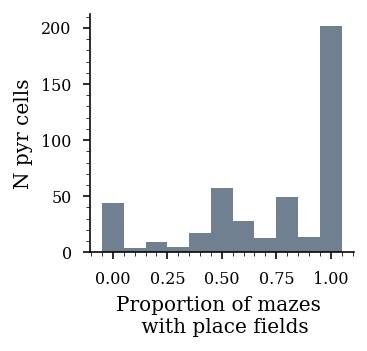

In [7]:
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5,1)), edgecolor='k')

bin_width = .1
bins = (np.arange(0,1.2,bin_width)-.05)
binned,_ = np.histogram(df_unit.sig_pc_prop,bins=bins)

plt.bar(bins[:-1]+bin_width/2,binned,width=bin_width,color="slategrey")

plt.xlabel('Proportion of mazes \n with place fields')
plt.ylabel('N pyr cells')

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'prob_place_cell_epochs.svg'),dpi=300,bbox_inches='tight')


## Cells with place fields in all mazes participation

In [8]:
ripple_particip = []
deepSuperficial = []

for df_temp in df_unit.itertuples():
    df_cell_metrics,data_ = loading.load_cell_metrics(df_temp.basepath)
    ripple_particip.append(df_cell_metrics[df_cell_metrics.UID == df_temp.UID].ripple_particip.values)
    deepSuperficial.append(df_cell_metrics[df_cell_metrics.UID == df_temp.UID].deepSuperficial.values)

df_unit['ripple_particip'] = np.vstack(ripple_particip)
df_unit['deepSuperficial'] = np.vstack(deepSuperficial)

df_unit

,sig_pc_prop,UID,basepath,n_epochs,ripple_particip,deepSuperficial
0,1.000,1.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.377517,Deep
1,1.000,2.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.229866,Deep
2,1.000,3.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.465884,Deep
3,1.000,4.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.378076,Deep
4,1.000,5.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.272371,Deep
...,...,...,...,...,...,...
437,1.000,90.0,Z:\Data\Kenji\ec013.868_893,8,0.161978,Superficial
438,0.875,92.0,Z:\Data\Kenji\ec013.868_893,8,0.442313,Deep
439,0.750,99.0,Z:\Data\Kenji\ec013.868_893,8,0.142938,Deep
440,0.500,100.0,Z:\Data\Kenji\ec013.868_893,8,0.302927,Superficial


### prop_place_fields_rip_particip weighted regression

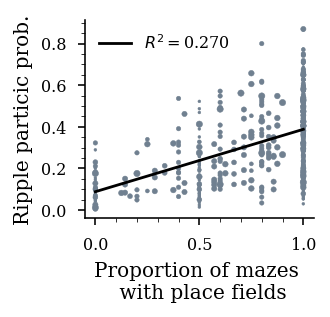

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1,1)), edgecolor='k')
sc=plt.scatter(df_unit.sig_pc_prop,df_unit.ripple_particip,s=df_unit.n_epochs,alpha=1,color='slategrey')
plt.legend(*sc.legend_elements("sizes", num=5))

plt.xlabel('Proportion of mazes \n with place fields')
plt.ylabel('Ripple particic prob.')

# polyreg=make_pipeline(PolynomialFeatures(1),LinearRegression())
polyreg=make_pipeline(LinearRegression())
X = df_unit.sig_pc_prop.values.reshape(-1, 1)
y = df_unit.ripple_particip.values
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
weights = df_unit.n_epochs.values

polyreg.fit(X,y,linearregression__sample_weight=weights)
plt.plot(X_seq,polyreg.predict(X_seq),color="black",label='$R^2=$'+str('%.3f'%(polyreg.score(X,y))))

ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.set_yscale('log')
plt.savefig(os.path.join(fig_save_path,'prop_place_fields_rip_particip.svg'),dpi=300,bbox_inches='tight')

<AxesSubplot:xlabel='sig_pc_prop', ylabel='particip_prob_ratio'>

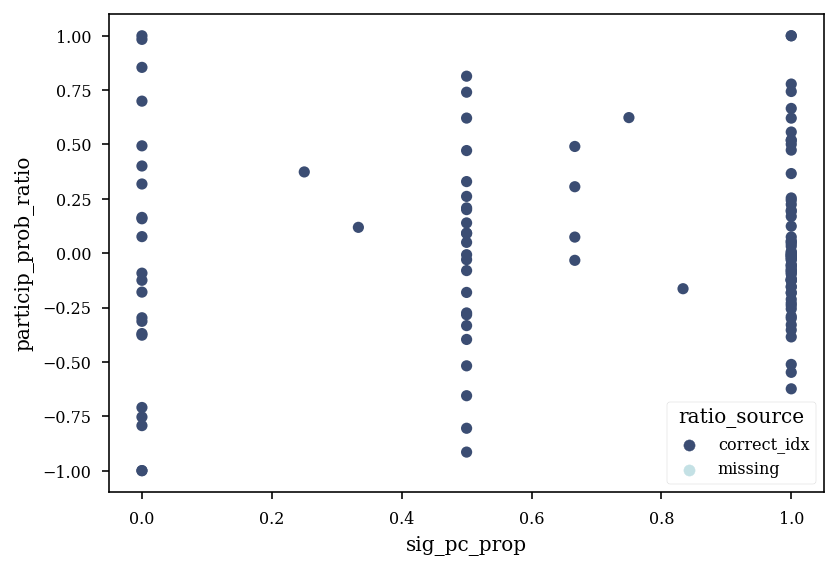

In [43]:
df_ratios = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_participation_stability_pre_task_post.csv')

particip_prob_ratio = []
fr_ratio = []
source = []
for temp_df in df_unit.itertuples():

    idx = (df_ratios.basepath == temp_df.basepath) & (df_ratios.UID == temp_df.UID)
    if sum(idx)>1:
        particip_prob_ratio.append(np.nanmean(df_ratios[idx].particip_prob_ratio.values))
        fr_ratio.append(np.nanmean(df_ratios[idx].fr_ratio.values))
        source.append('incorrect_idx')
    elif sum(idx) == 1:
        particip_prob_ratio.append(df_ratios[idx].particip_prob_ratio.values)
        fr_ratio.append(df_ratios[idx].fr_ratio.values)
        source.append('correct_idx')
    else:
        particip_prob_ratio.append(np.nan)
        fr_ratio.append(np.nan)
        source.append('missing')
        
df_unit['particip_prob_ratio'] = np.hstack(particip_prob_ratio)
df_unit['fr_ratio'] = np.hstack(fr_ratio)
df_unit['ratio_source'] = np.hstack(source)

sns.scatterplot(x="sig_pc_prop", y="particip_prob_ratio",
                hue="ratio_source",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=df_unit)
# df_unit

## Is place field propensity larger in CA1deep than CA1sup 


In [10]:
import loading
def add_rem_shift(df):

    df.loc[:,'rem_shift'] = False
    df.loc[:,'non_rem_shift'] = False
    df.loc[:,'m_wake'] = np.nan
    df.loc[:,'m_rem'] = np.nan
    df.loc[:,'p_rem'] = np.nan
    df.loc[:,'p_wake'] = np.nan
    df.loc[:,'circ_dist'] = np.nan

    for basepath in df.basepath.unique():
        df_rem_shift, _ = loading.load_theta_rem_shift(basepath)
        if df_rem_shift.shape[0] == 0:
            continue

        # restrict rem shift df to valid UIDs from df
        df_rem_shift = df_rem_shift[np.in1d(df_rem_shift.UID,df[df.basepath == basepath].UID)]
        # get index of current basepath
        # idx = (df.basepath==basepath).values
        idx = df.basepath==basepath
        
        df.loc[idx,"rem_shift"] = (df_rem_shift.rem_shift==1).values
        df.loc[idx,"non_rem_shift"] = (df_rem_shift.non_rem_shift==1).values

        df.loc[idx,"m_rem"] = df_rem_shift.m_rem.values
        df.loc[idx,"m_wake"] = df_rem_shift.m_wake.values
        df.loc[idx,"p_rem"] = df_rem_shift.p_rem.values
        df.loc[idx,"p_wake"] = df_rem_shift.p_wake.values
        df.loc[idx,"circ_dist"] = df_rem_shift.circ_dist.values
        
    df.loc[df.rem_shift == True,"rem_shift"] = "rem_shifting"
    df.loc[df.rem_shift == False,"rem_shift"] = "unknown"

    df.loc[df.non_rem_shift == True,"non_rem_shift"] = "non_rem_shifting"
    df.loc[df.non_rem_shift == False,"non_rem_shift"] = "unknown" 

    layer_rem_shift = []
    for temp_df in df.itertuples():
        if (temp_df.rem_shift == "rem_shifting") & (temp_df.deepSuperficial == "Deep"):
            layer_rem_shift.append("deep_rem_shift")
        elif (temp_df.non_rem_shift == "non_rem_shifting") & (temp_df.deepSuperficial == "Superficial"):
            layer_rem_shift.append("sup_non_rem_shift")
        else:
            layer_rem_shift.append("unknown")
    df['layer_rem_shift'] = layer_rem_shift
    
    return df
    
df_unit = add_rem_shift(df_unit)



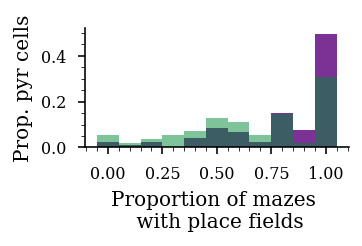

In [17]:
group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 

from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5,2)), edgecolor='k')

bin_width = .1
bins = (np.arange(0,1.2,bin_width)-.05)
binned,_ = np.histogram(df_unit[df_unit.layer_rem_shift=='deep_rem_shift'].sig_pc_prop,bins=bins)
plt.bar(bins[:-1]+bin_width/2,binned/binned.sum(),width=bin_width,color="#7b3294")

binned,_ = np.histogram(df_unit[df_unit.layer_rem_shift=='sup_non_rem_shift'].sig_pc_prop,bins=bins)
plt.bar(bins[:-1]+bin_width/2,binned/binned.sum(),width=bin_width,color="#008837",alpha=.5)

plt.xlabel('Proportion of mazes \n with place fields')
plt.ylabel('Prop. pyr cells')

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'place_cell_prop_deep_sup.svg'),dpi=300,bbox_inches='tight')


## Do cells with higher spatial specificity have the largest SWR participation increase post-task?

In [19]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.pkl')
    
    results = pd.DataFrame()
    
    for session in sessions:
        with open(session, 'rb') as f:
            result = pickle.load(f)
        df1 = result['df']

        n_spikes = [len(st) for st in result['st']]
        df1['n_spikes'] = n_spikes
        peak_rate = []
        for map_ in result['ratemaps']:
            if len(map_) == 0:
                peak_rate.append(0)
            else: 
                peak_rate.append(map_.max())
        if len(peak_rate) == 0:
            df1['peak_rate'] = peak_rate
        else:        
            df1['peak_rate'] = np.vstack(peak_rate)

        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\place_cell'

df = load_in_everything(save_path)

In [20]:
df_ratios = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_participation_stability_pre_task_post.csv')
spatial_infos = []
source = []
for temp_df in df_ratios.itertuples():
    basepath = temp_df.basepath
    idx = (df.basepath == basepath) & (df.UID == temp_df.UID) & (df.environment == temp_df.task)
    if sum(idx)>1:
        spatial_infos.append(np.nanmean(df[idx].spatial_infos))
        source.append('incorrect_idx')
    elif sum(idx) == 1:
        spatial_infos.append(df[idx].spatial_infos.values)
        source.append('correct_idx')
    else:
        spatial_infos.append(np.nan)
        source.append('missing')
    # pvals
    
df_ratios['spatial_infos'] = np.hstack(spatial_infos)
df_ratios['source'] = np.hstack(source)

df_ratios = df_ratios[~np.isnan(df_ratios.spatial_infos)]
df_ratios

,Unnamed: 0,basepath,UID,task,n_spikes,deepSuperficial,fr_ratio,particip_prob_ratio,spatial_infos,source
0,0,Z:\Data\AYAold\AB3\AB3_38_41,1,tmaze,1602.0,Deep,0.266966,-0.124604,1.288817,correct_idx
1,1,Z:\Data\AYAold\AB3\AB3_38_41,2,tmaze,680.0,Deep,0.112032,-0.012372,3.065626,correct_idx
2,2,Z:\Data\AYAold\AB3\AB3_38_41,3,tmaze,3306.0,Deep,0.024308,-0.256041,1.025667,correct_idx
3,3,Z:\Data\AYAold\AB3\AB3_38_41,4,tmaze,2079.0,Deep,0.127765,-0.240106,1.283747,correct_idx
4,4,Z:\Data\AYAold\AB3\AB3_38_41,5,tmaze,1359.0,Deep,0.045089,-0.096372,1.215658,correct_idx
...,...,...,...,...,...,...,...,...,...,...
2891,2891,Z:\Data\Kenji\ec016.577_590,80,bigSquare,865.0,Deep,-0.170792,-0.048885,3.162609,correct_idx
2892,2892,Z:\Data\Kenji\ec016.577_590,82,bigSquare,913.0,Deep,0.562414,0.045178,0.596953,correct_idx
2893,2893,Z:\Data\Kenji\ec016.577_590,84,bigSquare,72.0,Deep,-0.934713,-0.170578,3.389118,correct_idx
2894,2894,Z:\Data\Kenji\ec016.577_590,86,bigSquare,799.0,Deep,-0.223416,0.018549,2.301927,correct_idx


<AxesSubplot:xlabel='spatial_infos', ylabel='particip_prob_ratio'>

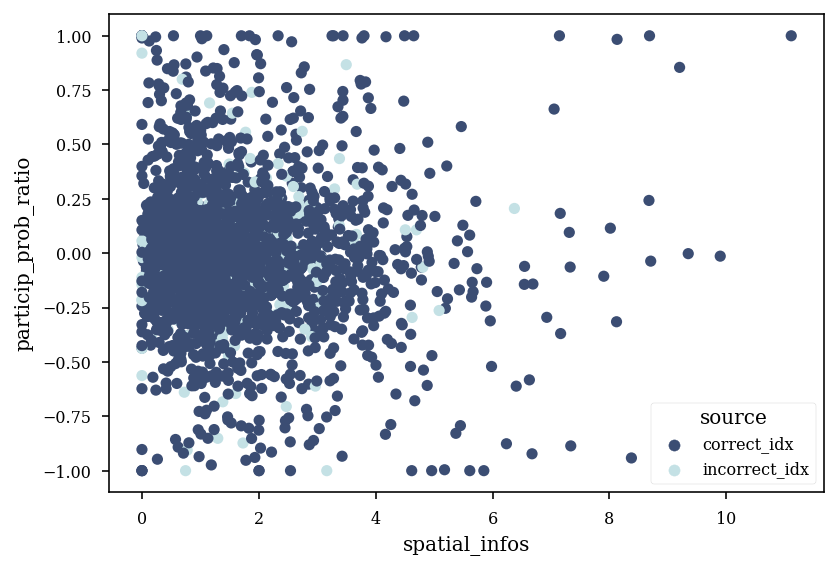

In [25]:
sns.scatterplot(x="spatial_infos", y="particip_prob_ratio",
                hue="source",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=df_ratios)

No handles with labels found to put in legend.


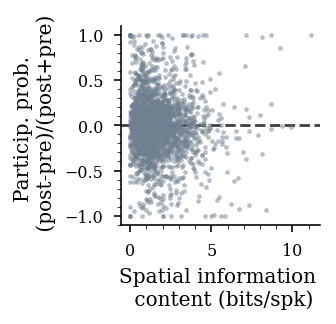

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1,1)), edgecolor='k')
plt.scatter(df_ratios.spatial_infos,df_ratios.particip_prob_ratio,alpha=.5,s=4,color='slategrey',rasterized=True)

plt.xlabel('Spatial information \n content (bits/spk)')
plt.ylabel('Particip. prob. \n (post-pre)/(post+pre)')

# polyreg=make_pipeline(LinearRegression())
# polyreg=make_pipeline(PolynomialFeatures(1),RANSACRegressor())
polyreg=make_pipeline(RANSACRegressor())

X = df_ratios.spatial_infos.values.reshape(-1, 1)
y = df_ratios.particip_prob_ratio.values
good_idx = ~np.isnan(X.T) & ~np.isnan(y)
X = X[good_idx[0]]
y = y[good_idx[0]]
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)

polyreg.fit(X,y)
# plt.plot(X_seq,polyreg.predict(X_seq),color="black",label='$R^2=$'+str('%.3f'%(polyreg.score(X,y))))

plt.ylim(-1.1,1.1)
ax = plt.gca()

ax.axhline(0,color='k',ls='--',alpha=.75,zorder=-100)

# ax.set_aspect('equal', 'box')
ax.set_aspect(1./ax.get_data_ratio())

ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'partic_gain_spatial_info.svg'),dpi=300,bbox_inches='tight')


No handles with labels found to put in legend.


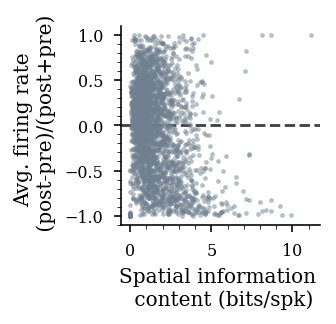

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1,1)), edgecolor='k')
plt.scatter(df_ratios.spatial_infos,df_ratios.fr_ratio,alpha=.5,s=4,color='slategrey',rasterized=True)

plt.xlabel('Spatial information \n content (bits/spk)')
plt.ylabel('Avg. firing rate \n (post-pre)/(post+pre)')

polyreg=make_pipeline(RANSACRegressor())
X = df_ratios.spatial_infos.values.reshape(-1, 1)
y = df_ratios.fr_ratio.values
good_idx = ~np.isnan(X.T) & ~np.isnan(y)
X = X[good_idx[0]]
y = y[good_idx[0]]
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)

polyreg.fit(X,y)
# plt.plot(X_seq,polyreg.predict(X_seq),color="black",label='$R^2=$'+str('%.3f'%(polyreg.score(X,y))))

plt.ylim(-1.1,1.1)
ax = plt.gca()

ax.axhline(0,color='k',ls='--',alpha=.75,zorder=-100)

# ax.set_xscale('log')

# ax.set_aspect('equal', 'box')
ax.set_aspect(1./ax.get_data_ratio())

ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'fr_gain_spatial_info.svg'),dpi=300,bbox_inches='tight')


## Place cell example figure

KeyboardInterrupt: 

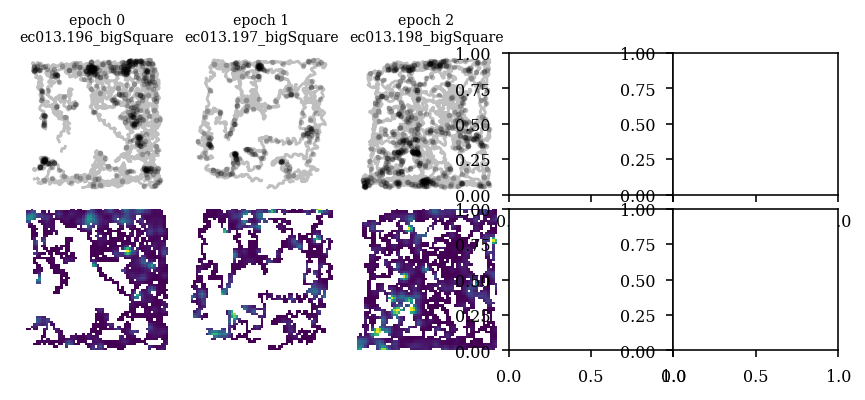

In [83]:
def plot_place_cells(basepath,unit_id,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')

    beh_df = loading.load_animal_behavior(basepath)

    epoch_df = loading.load_epoch(basepath)
    # remove sleep and wheel running
    epoch_df = epoch_df[(epoch_df.environment != 'sleep') & (epoch_df.environment != 'wheel')]
    # remove sessions < 5 minutes
    epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime)/60 > 5]

    with open(save_file, 'rb') as f:
        result = pickle.load(f)

    ratemaps = np.array(result['ratemaps'])[result['df']['UID'] == unit_id]   
    occ = np.array(result['occupancies'])[result['df']['UID'] == unit_id]   

    # x = np.array(result['x'])[result['df']['UID'] == unit_id]   
    # y = np.array(result['y'])[result['df']['UID'] == unit_id]   
    name = result['df'].name.values[result['df']['UID'] == unit_id]  
    st = np.array(result['st'])[result['df']['UID'] == unit_id]   

    # n_panels = int(np.ceil(len(ratemaps)/2))
    n_panels = len(ratemaps)
    fig,axs = plt.subplots(2,n_panels, figsize=functions.set_size('thesis', fraction=1.25, subplots=(3,n_panels)), edgecolor='k')
    fig.subplots_adjust(hspace = 0.1, wspace=0)
    axs = axs.ravel()

    max_rate = [np.max(r) for r in ratemaps]
    v_max = np.min(max_rate)

    for i in range(len(ratemaps)):
        # axs[i].imshow(ratemaps[i])
        # plt.plot(x[i],y[i])

        ts = beh_df[beh_df['time'].between(epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime)].time
        x1 = beh_df[beh_df['time'].between(epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime)].x
        y1 = beh_df[beh_df['time'].between(epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime)].y

        if (len(x1) == 0) | (len(st[i]) == 0):
            test=1

        axs[i].plot(x1,y1,color='grey',alpha=.5)
        axs[i].plot(np.interp(st[i],ts,x1),np.interp(st[i],ts,y1),'.k',alpha=.25)
        axs[i].axis('equal')
        axs[i].axis('off')

        axs[i].set_title('epoch '+str(i)+'\n'+name[i],fontsize=7)
        # axs[i].show()
        # ratemap_,_ = get_ratemap(ts,x1,y1,st[i],bin_width=3,smooth_sigma=1,add_nan_back=True)
    
        ratemap_ = ratemaps[i].copy()
        ratemap_[occ[i]<.01] = np.nan
        axs[i+len(ratemaps)].imshow(ratemap_,interpolation='nearest',origin='lower',vmax=np.nanmax(ratemap_)*.9)
        axs[i+len(ratemaps)].axis('off')

        # sns.heatmap(ratemaps[i],ax=axs[i+len(ratemaps)])
        axs[i+len(ratemaps)].axis('equal')

# place_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\place_cell_examples'
# for df_temp in df_unit.itertuples():
#     plot_place_cells(df_temp.basepath,df_temp.UID,save_path)
#     save_file = os.path.join(place_save_path,df_temp.basepath.replace(os.sep, "_").replace(":", "_")+str(df_temp.UID)+'.png')

#     plt.savefig(save_file,dpi=300,bbox_inches='tight')
#     plt.close()

basepath = 'Z:\\Data\\Kenji\\ec013.194_213'
UID = 73.0
plot_place_cells(basepath,UID,save_path)


In [25]:
df_unit.basepath.iloc[0].replace(os.sep, "_").replace(":", "_")
# save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')


'Z__Data_AYAold_AB3_AB3_38_41'

## Testing below

In [88]:
np.sum(sig_pc[0] & sig_pc[1])
sig_pc[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True])

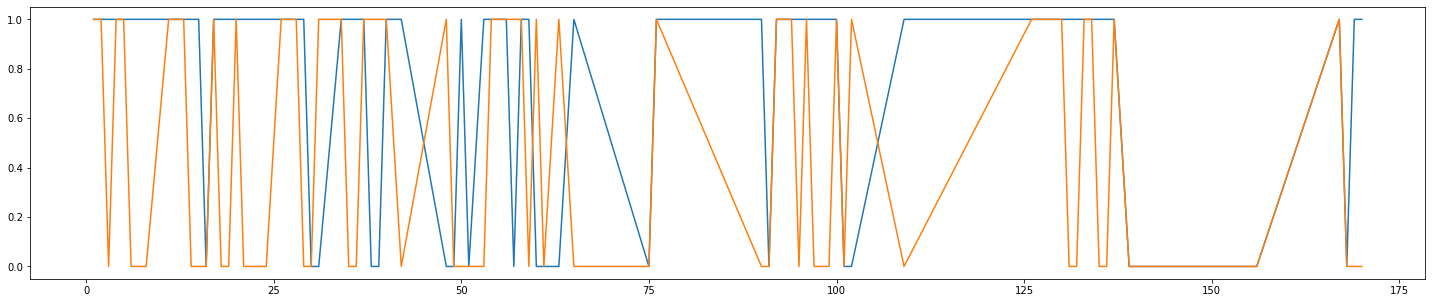

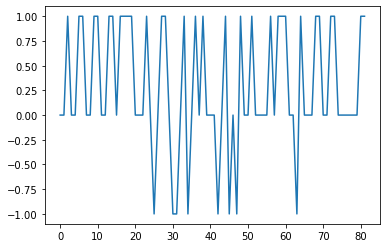

In [90]:
plt.figure(figsize=(25,5))
plt.plot(np.array(UID[0]),np.array(sig_pc[0]))
plt.plot(np.array(UID[1]),np.array(sig_pc[1]))
plt.show()

plt.plot(np.array(sig_pc[0])*1-np.array(sig_pc[1])*1)

# np.all(np.array(UID[0])-np.array(UID[1]))

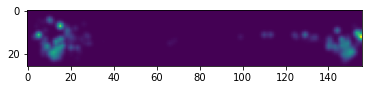

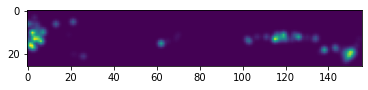

In [9]:
plt.imshow(results['ratemaps'][0])
plt.show()
plt.imshow(results['ratemaps'][10])
# plt.colorbar()
# results['ratemaps']

In [3]:
epoch_df = loading.load_epoch(basepath)
# epoch_df = functions.compress_repeated_epochs(epoch_df)
epoch_df = epoch_df[(epoch_df.environment != 'sleep') & (epoch_df.environment != 'wheel')]

epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime)/60 > 5]

for i,ep in enumerate(epoch_df.itertuples()):
    if ep.environment == 'linear':
        x = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].x
        y = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].y

        x,y = functions.linearize_position(x,y)
        beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'x'] = x
        beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'y'] = y

display(epoch_df)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])

for ep in beh_epochs:
    print(ep.duration)

pos = nel.AnalogSignalArray(data=np.array([beh_df.x,beh_df.y]),
                            timestamps=beh_df.time,
                            fs=1/statistics.mode(np.diff(beh_df.time)))

,name,startTime,stopTime,environment,behavioralParadigm
3,ec013.454_linear,2756.8552,3758.3272,linear,10
7,ec013.459_bigSquare,8065.2710,9146.6150,bigSquare,10
8,ec013.460_bigSquare,9146.6150,11318.7240,bigSquare,10
9,ec013.462_bigSquare,11318.7240,12316.8240,bigSquare,10
10,ec013.463_bigSquare,12316.8240,14083.3240,bigSquare,10
12,ec013.465_linear,14320.3240,15257.7240,linear,10
13,ec013.466_linear,15257.7240,16306.3000,linear,10
14,ec013.469_linear,16306.3000,17113.2120,linear,10


16:41:472 minutes
18:01:344 minutes
36:12:109 minutes
16:38:100 minutes
29:26:500 minutes
15:37:400 minutes
17:28:576 minutes
13:26:912 minutes


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1796b153ca0: 2 signals> for a total of 5:00:59.11040000000000001 hours

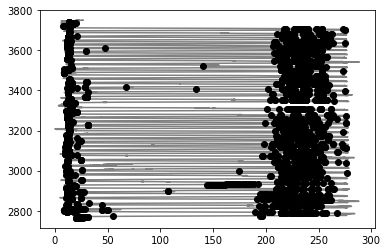

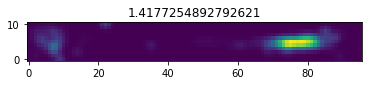

In [9]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate

def get_ratemap(ts,x,y,st,bin_width=3,smooth_sigma=1):

    fs = 1/statistics.mode(np.diff(ts))

    x_edges = np.arange(np.nanmin(x),np.nanmax(x),bin_width)
    y_edges = np.arange(np.nanmin(y),np.nanmax(y),bin_width)

    occ,_,_ = np.histogram2d(x,y,bins=(x_edges,y_edges))
    occ = occ/fs

    spk_mat,_,_ = np.histogram2d(np.interp(st,ts,x),np.interp(st,ts,y),bins=(x_edges,y_edges))

    ratemap = spk_mat / occ
    ratemap[np.isnan(ratemap)] = 0
    ratemap[np.isinf(ratemap)] = 0

    ratemap = gaussian_filter(ratemap, sigma=smooth_sigma)

    ratemap = rotate(ratemap, angle=-90)
    occ = rotate(occ, angle=-90)
    
    ratemap = np.fliplr(ratemap)
    occ = np.fliplr(occ)

    return ratemap,occ

speed = nel.utils.ddt_asa(pos[beh_epochs[0]], smooth=True, sigma=.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[0]][run_epochs] 
pos_run = pos[beh_epochs[0]][run_epochs] 

ts = pos_run.abscissa_vals
x = pos_run.data[0,:]
y = pos_run.data[1,:]

cell_id = 1
# for cell_id in range(len(st_unit.data)):
plt.plot(x,ts,color='grey',zorder=-1000)
# plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

# plt.axis('equal')
plt.show()

ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])

plt.imshow(ratemap,origin='lower',interpolation="nearest")
plt.title(functions.spatial_information(ratemap,occupancy))
plt.show()


In [18]:
import warnings
warnings.filterwarnings("ignore")

def surrogate_test_spatial_info(ts,x,y,s,n_shuff=1000):

    def shuff_coords(x,y,n_shuff):
        range_ = len(x)

        surrogate = np.random.choice(np.arange(-range_, range_), size=n_shuff,replace=False)
        x_temp = []
        y_temp = []
        for n in surrogate:
            x_temp.append(np.roll(x, n))
            y_temp.append(np.roll(y, n))
        return x_temp,y_temp

    def pvalue(shuff_dist,score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

    ratemap,occupancy = get_ratemap(ts,x,y,s)
    obs_ic = functions.spatial_information(ratemap,occupancy)

    x_temp,y_temp = shuff_coords(x,y,n_shuff)

    null_ic = []

    for new_xy in zip(x_temp,y_temp):
        ratemap,occupancy = get_ratemap(ts,new_xy[0],new_xy[1],s)
        null_ic.append(functions.spatial_information(ratemap,occupancy))

    return pvalue(null_ic,obs_ic),null_ic,obs_ic

ep = 1
cell_id = 2
speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[ep]][run_epochs] 
pos_run = pos[beh_epochs[ep]][run_epochs] 

ts = pos_run.abscissa_vals
x = pos_run.data[0,:]
y = pos_run.data[1,:]

pval,null,obs = surrogate_test_spatial_info(ts,x,y,st_run.data[cell_id],n_shuff=1000)    

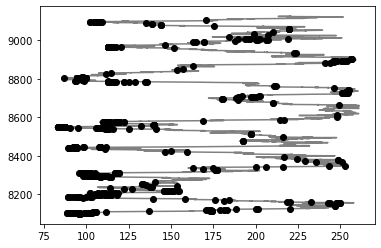

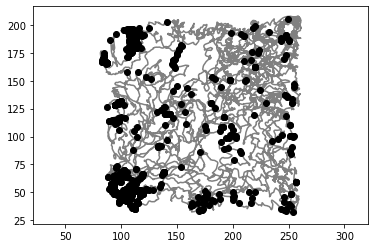

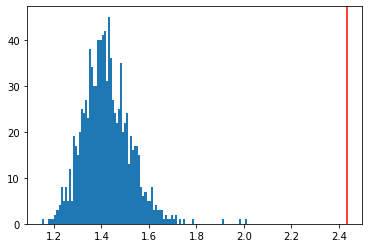

0.000999000999000999


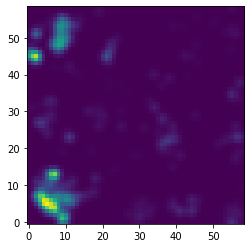

In [19]:
plt.plot(x,ts,color='grey',zorder=-1000)
plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

plt.figure()
plt.plot(x,y,color='grey',zorder=-1000)
plt.scatter(np.interp(st_run.data[cell_id],ts,x),np.interp(st_run.data[cell_id],ts,y),color='k')
plt.axis('equal')

plt.figure()
plt.hist(null,100)
plt.axvline(obs,color='r')
plt.show()
print(pval)

plt.figure()
ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])
plt.imshow(ratemap,origin='lower',interpolation="nearest")

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


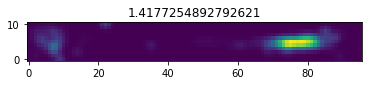

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


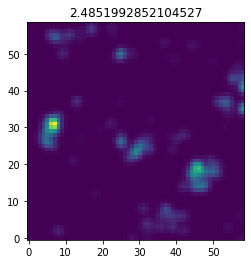

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


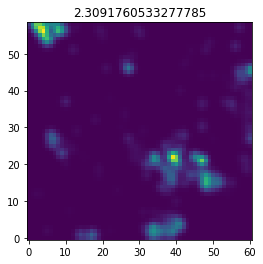

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


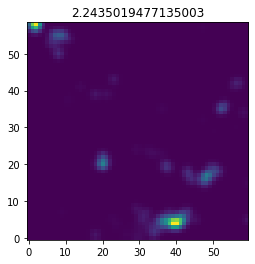

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


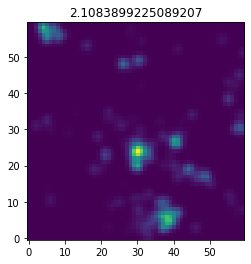

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


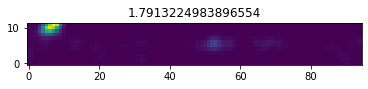

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


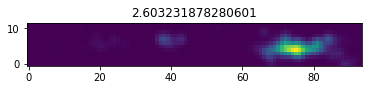

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


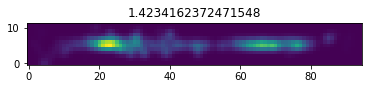

In [191]:
for ep in range(beh_epochs.n_intervals):
    speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=.1, norm=True)
    run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
    st_run = st_unit[beh_epochs[ep]][run_epochs] 
    pos_run = pos[beh_epochs[ep]][run_epochs] 

    ts = pos_run.abscissa_vals
    x = pos_run.data[0,:]
    y = pos_run.data[1,:]

    cell_id = 1
    # for cell_id in range(len(st_unit.data)):
    plt.figure()
    # plt.plot(x,y,color='grey',zorder=-1000)
    # plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
    # # plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

    # plt.axis('equal')

    ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])

    plt.imshow(ratemap,origin='lower',interpolation="nearest")
    plt.title(functions.spatial_information(ratemap,occupancy))
    plt.show()
